
# Sentiment Analysis on Movie Reviews

##  1.Description:

## <img src='https://imgur.com/FC94FVr.jpg'>

"There's a thin line between likably old-fashioned and fuddy-duddy, and The Count of Monte Cristo ... never quite settles on either side."

The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee.

In their work on sentiment treebanks, Socher et al. used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

## <img src='https://imgur.com/HbAuQZq.jpg'>

### 1.1 Data Description:

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative<br>
1 - somewhat negative<br>
2 - neutral<br>
3 - somewhat positive<br>
4 - positive

### 1.2 Objective:

Classify the sentiment of sentences from the Rotten Tomatoes dataset 

### 1.3 Sources/Useful Links:

http://nlp.stanford.edu/sentiment/ <br>
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview

## 2. Machine Learning Problem

### 2.1 Data

### 2.1.1 Data Overview

Get the data from :  https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

- Data will be in a file Train.tsv and Test.tsv 
- Size of Train.tsv - 8.08 MB 
- Size of Test.tsv - 3.21 MB 
- Number of rows and columns in Train.tsv = 156k x 4
- Number of rows and columns in Test.tsv = 66.3k x 3




### 2.1.2 Train and Test Construction

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

## 3. Exploratory Data Analysis

### 3.1 Importing important libraries

In [51]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stopwords = stopwords.words('english')#choosen the english language

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer,SnowballStemmer
import re\

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

### 3.2 Reading data and basic stats

In [132]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
#loading data from HDD
train_df = pd.read_csv('train.tsv' , sep="\t")
print("Train shape : ", train_df.shape)
test_df = pd.read_csv('test.tsv' , sep="\t")
print("Test shape : ", test_df.shape)

Train shape :  (156060, 4)
Test shape :  (66292, 3)


In [104]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [105]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### 3.2 Checking for missing values

In [106]:
def check_missing_values(df):
    
    if df.isnull().any().any():
        print("There are missing values in the data")  
    else: 
        print("There are no missing values in the data")

In [107]:
#calling functions to check missing values on training and test datasets
check_missing_values(train_df)
check_missing_values(test_df)

There are no missing values in the data
There are no missing values in the data


### 3.3 Ploting

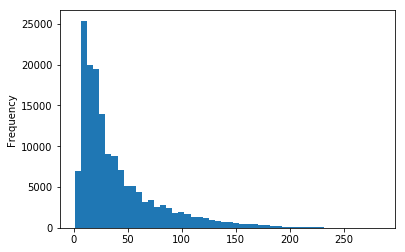

In [108]:
# plot on Phrase 
train_df['Text_length']=train_df['Phrase'].apply(len)
train_df['Text_length'].plot.hist(bins=50)

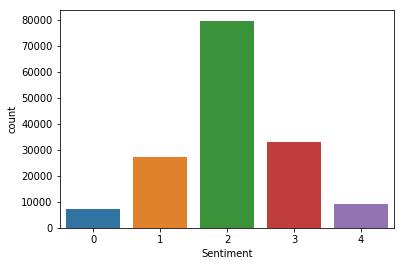

In [109]:
# Plot on Sentiment

sns.countplot(train_df['Sentiment'])


### 3.4 Pre Processing

In [133]:
%%time
#Pre Processing 


#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
stop = set(stopwords.words('english')) #set of stopwords
porter = PorterStemmer()
snowball = SnowballStemmer('english')

#final_150000 = df_sample.head(150000)#taking 150000 datapoints

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

    str1=[];

for sent in train_df['Phrase'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    sent=cleanpunc(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(snowball.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    #str1 =b" ".join(filtered_sentence) #final string of cleaned words
    str1 =b' '.join(filtered_sentence).decode()
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

Wall time: 29.4 s


In [134]:
#adding a column of CleanedText which displays the data after pre-processing of the review 
train_df['clean_text']=final_string

print(train_df.shape)

(156060, 5)


In [135]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_text
0,1,1,A series of escapades demonstrating the adage ...,1,seri escapad demonstr adag good goos also good...
1,2,1,A series of escapades demonstrating the adage ...,2,seri escapad demonstr adag good goos
2,3,1,A series,2,seri
3,4,1,A,2,
4,5,1,series,2,seri


## 4. Machine Learning Models

In [136]:
%%time
#Using TFIDF
#for Train data set
X_train, X_test, y_train, y_test = train_test_split(train_df['clean_text'].values, train_df['Sentiment'].values ,test_size=0.30,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=45728)
X_train = tfidf.fit_transform(X_train)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = tfidf.transform(X_test)
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (109242, 45728)
Test Data Size:  (46818, 45728)
Wall time: 3.27 s


In [137]:
#for Test data set
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_test_final = tfidf.fit_transform(test_df['Phrase'].values)

#Normalize Data
X_test_final = preprocessing.normalize(X_test_final)
print("Test Data Size: ",X_test_final.shape)

Test Data Size:  (66292, 45728)


### Logistic Regression Model
##### Hyperparameter Tunning

In [ ]:
#Hyperparameter Tunning

from sklearn.model_selection import GridSearchCV # Finding the best "Alpha" using forward chaining cross validation
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
param_grid ={'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005
                  ,0.001,0.0005,0.0001],'penalty':['l1','l2']} #params we need to try on classifier

tscv = TimeSeriesSplit(n_splits=10) #For time based splitting

grid = GridSearchCV(LR, param_grid, cv=tscv, verbose=1)# instantiate the grid
grid.fit(X_train,y_train)

#SaveToFile(grid,"LR-Uni-Gram")

In [139]:
print("Best HyperParameter: ",grid.best_params_)
print("Best Accuracy: %.2f%%"%(grid.best_score_*100))


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 55.51%


#### Building Model 

In [140]:
# testing accuracy on the best_estimator

LR = LogisticRegression(C=1,penalty='l1')
LR.fit(X_train,y_train)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [143]:
# Predict on test
y_pred = LR.predict(X_test)
#y_pred = LR.predict(X_test_final)# for final results of csv file


## Conclyution: 

### Accuracy_score:

In [145]:
#accuracy_score 

print('Accuracy_score:',metrics.accuracy_score(y_test, y_pred))


Accuracy_score: 0.5776837968302789


### Exporting it to csv file:

In [142]:
#exporting final results into csv file
#test_df = pd.read_csv('test.csv')

csvfile = pd.DataFrame()
csvfile['PhraseId'] = test_df['PhraseId']
csvfile['Sentiment'] = y_pred
csvfile.to_csv('Sentiments_csv_file.csv', index=False)

### Kaggle Score: 

## <img src='https://imgur.com/3eRDxo0.jpg'>



                                                            ---xxx---